The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [5]:
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6


  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-ju8ua4zc
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-ju8ua4zc
  Created wheel for d2l: filename=d2l-0.11.3-cp36-none-any.whl size=28484 sha256=25d96d686c0e7e0c05c22973bdba234fa54dfc774bce2b60666162a92ce87481
  Stored in directory: /tmp/pip-ephem-wheel-cache-dffg69sm/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l
Requirement already up-to-date: mxnet-cu101mkl in /usr/local/lib/python3.6/dist-packages (1.6.0)


# Convolutional Neural Networks (LeNet)

:label:`sec_lenet`


We are now ready to put all of the tools together
to deploy your first fully-functional convolutional neural network.
In our first encounter with image data we applied a multilayer perceptron (:numref:`sec_mlp_scratch`)
to pictures of clothing in the Fashion-MNIST dataset.
Each image in Fashion-MNIST consisted of
a two-dimensional $28 \times 28$ matrix.
To make this data amenable to multilayer perceptrons
which anticipate receiving inputs as one-dimensional fixed-length vectors,
we first flattened each image, yielding vectors of length 784,
before processing them with a series of fully-connected layers.

Now that we have introduced convolutional layers,
we can keep the image in its original spatially-organized grid,
processing it with a series of successive convolutional layers.
Moreover, because we are using convolutional layers,
we can enjoy a considerable savings in the number of parameters required.

In this section, we will introduce one of the first
published convolutional neural networks
whose benefit was first demonstrated by Yann Lecun,
then a researcher at AT&T Bell Labs,
for the purpose of recognizing handwritten digits in images—[LeNet5](http://yann.lecun.com/exdb/lenet/).
In the 90s, their experiments with LeNet gave the first compelling evidence
that it was possible to train convolutional neural networks
by backpropagation.
Their model achieved outstanding results at the time
(only matched by Support Vector Machines at the time)
and was adopted to recognize digits for processing deposits in ATM machines.
Some ATMs still run the code
that Yann and his colleague Leon Bottou wrote in the 1990s!

## LeNet

In a rough sense, we can think LeNet as consisting of two parts:
(i) a block of convolutional layers; and
(ii) a block of fully-connected layers.
Before getting into the weeds, let's briefly review the model in :numref:`img_lenet`.

![Data flow in LeNet 5. The input is a handwritten digit, the output a probability over 10 possible outcomes.](http://d2l.ai/_images/lenet.svg)

:label:`img_lenet`


The basic units in the convolutional block are a convolutional layer
and a subsequent average pooling layer
(note that max-pooling works better,
but it had not been invented in the 90s yet).
The convolutional layer is used to recognize
the spatial patterns in the image,
such as lines and the parts of objects,
and the subsequent average pooling layer
is used to reduce the dimensionality.
The convolutional layer block is composed of
repeated stacks of these two basic units.
Each convolutional layer uses a $5\times 5$ kernel
and processes each output with a sigmoid activation function
(again, note that ReLUs are now known to work more reliably,
but had not been invented yet).
The first convolutional layer has 6 output channels,
and second convolutional layer increases channel depth further to 16.

However, coinciding with this increase in the number of channels,
the height and width are shrunk considerably.
Therefore, increasing the number of output channels
makes the parameter sizes of the two convolutional layers similar.
The two average pooling layers are of size $2\times 2$ and take stride 2
(note that this means they are non-overlapping).
In other words, the pooling layer downsamples the representation
to be precisely *one quarter* the pre-pooling size.

The convolutional block emits an output with size given by
(batch size, channel, height, width).
Before we can pass the convolutional block's output
to the fully-connected block, we must flatten
each example in the minibatch.
In other words, we take this 4D input and transform it into the 2D
input expected by fully-connected layers:
as a reminder, the first dimension indexes the examples in the minibatch
and the second gives the flat vector representation of each example.
LeNet's fully-connected layer block has three fully-connected layers,
with 120, 84, and 10 outputs, respectively.
Because we are still performing classification,
the 10 dimensional output layer corresponds
to the number of possible output classes.

While getting to the point
where you truly understand
what is going on inside LeNet
may have taken a bit of work,
you can see below that implementing it
in a modern deep learning library
is remarkably simple.
Again, we will rely on the Sequential class.

In [0]:
import d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        # Dense will transform the input of the shape (batch size, channel,
        # height, width) into the input of the shape (batch size,
        # channel * height * width) automatically by default
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10))

As compared to the original network,
we took the liberty of replacing
the Gaussian activation in the last layer
by a regular dense layer, which tends to be
significantly more convenient to train.
Other than that, this network matches
the historical definition of LeNet5.

Next, let's take a look of an example.
As shown in :numref:`img_lenet_vert`, we feed 
a single-channel example
of size $28 \times 28$ into the network
and perform a forward computation layer by layer
printing the output shape at each layer
to make sure we understand what is happening here.

In [8]:
X = np.random.uniform(size=(1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (1, 6, 28, 28)
pool0 output shape:	 (1, 6, 14, 14)
conv1 output shape:	 (1, 16, 10, 10)
pool1 output shape:	 (1, 16, 5, 5)
dense0 output shape:	 (1, 120)
dense1 output shape:	 (1, 84)
dense2 output shape:	 (1, 10)


Note that the height and width of the representation
at each layer throughout the convolutional block is reduced
(compared to the previous layer).
The first convolutional layer uses a kernel
with a height and width of $5$, and then a $2$ pixels of padding 
which compensates the reduction in its original shape.
While the second convolutional layer applies the same shape of 
$5 x 5$ kernel without padding, resulting in reductions 
in both height and width by $4$ pixels.
Moreover each pooling layer halves the height and width.
However, as we go up the stack of layers,
the number of channels increases layer-over-layer
from 1 in the input to 6 after the first convolutional layer
and 16 after the second layer.
Then, the fully-connected layer reduces dimensionality layer by layer,
until emitting an output that matches the number of image classes.

![Compressed notation for LeNet5](https://github.com/d2l-ai/d2l-en-colab/blob/master/img/lenet-vert.svg?raw=1)

:label:`img_lenet_vert`


## Data Acquisition and Training

Now that we have implemented the model,
we might as well run some experiments
to see what we can accomplish with the LeNet model.
While it might serve nostalgia
to train LeNet on the original MNIST dataset,
that dataset has become too easy,
with MLPs getting over 98% accuracy,
so it would be hard to see the benefits of convolutional networks.
Thus we will stick with Fashion-MNIST as our dataset
because while it has the same shape ($28\times28$ images),
this dataset is notably more challenging.

In [9]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

While convolutional networks may have few parameters,
they can still be significantly more expensive
to compute than a similarly deep multilayer perceptron
so if you have access to a GPU, this might be a good time
to put it into action to speed up training.

For evaluation, we need to make a slight modification
to the `evaluate_accuracy` function that we described
in :numref:`sec_softmax_scratch`.
Since the full dataset lives on the CPU,
we need to copy it to the GPU before we can compute our models.
This is accomplished via the `as_in_context` function
described in :numref:`sec_use_gpu`.

In [0]:
# Saved in the d2l package for later use
def evaluate_accuracy_gpu(net, data_iter, ctx=None):
    if not ctx:  # Query the first device the first parameter is on
        ctx = list(net.collect_params().values())[0].list_ctx()[0]
    metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        metric.add(d2l.accuracy(net(X), y), y.size)
    return metric[0]/metric[1]

We also need to update our training function to deal with GPUs.
Unlike the `train_epoch_ch3` defined in :numref:`sec_softmax_scratch`, we now need to move each batch of data to our designated context (hopefully, the GPU)
prior to making the forward and backward passes.

The training function `train_ch6` is also very similar to `train_ch3` defined in :numref:`sec_softmax_scratch`. Since we will deal with networks with tens of layers now, the function will only support Gluon models. We initialize the model parameters on the device indicated by `ctx`,
this time using the Xavier initializer.
The loss function and the training algorithm
still use the cross-entropy loss function
and minibatch stochastic gradient descent. Since each epoch takes tens of
seconds to run, we visualize the training loss in a finer granularity.

In [0]:
# Saved in the d2l package for later use
def train_ch6(net, train_iter, test_iter, num_epochs, lr, ctx=d2l.try_gpu()):
    net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(),
                            'sgd', {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            # Here is the only difference compared to train_epoch_ch3
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (
        train_loss, train_acc, test_acc))
    print('%.1f examples/sec on %s' % (metric[2]*num_epochs/timer.sum(), ctx))

Now let's train the model.

loss 0.470, train acc 0.824, test acc 0.808
12424.0 examples/sec on gpu(0)


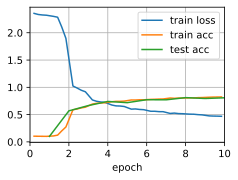

In [7]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

## Summary

* A convolutional neural network (in short, ConvNet) is a network using convolutional layers.
* In a ConvNet we alternate between convolutions, nonlinearities and often also pooling operations.
* Ultimately the resolution is reduced prior to emitting an output via one (or more) dense layers.
* LeNet was the first successful deployment of such a network.

## Exercises

1. Replace the average pooling with max pooling. What happens?
1. Try to construct a more complex network based on LeNet to improve its accuracy.
    * Adjust the convolution window size.
    * Adjust the number of output channels.
    * Adjust the activation function (ReLU?).
    * Adjust the number of convolution layers.
    * Adjust the number of fully connected layers.
    * Adjust the learning rates and other training details (initialization, epochs, etc.)
1. Try out the improved network on the original MNIST dataset.
1. Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters, coats).


## [Discussions](https://discuss.mxnet.io/t/2353)

![](http://d2l.ai/_images/qr_lenet.svg)

loss 0.403, train acc 0.851, test acc 0.840
12207.3 examples/sec on gpu(0)


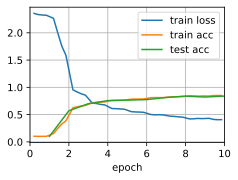

In [13]:
## Q1: replace average pooling with max pooling
npx.set_np()

netMP = nn.Sequential()
netMP.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10))

lr, num_epochs = 0.9, 10
train_ch6(netMP, train_iter, test_iter, num_epochs, lr)

In [0]:
## Q2: try out an imporoved version of netMP 
  # a) Adjust the convolution window size.
  # b) Adjust the number of output channels.
  # c) Adjust the activation function (ReLU?).
  # d) Adjust the number of convolution layers.
  # e) Adjust the number of fully connected layers.
  # f) Adjust the learning rates and other training details (initialization, epochs, etc.)

loss 2.304, train acc 0.104, test acc 0.100
1052.8 examples/sec on gpu(0)


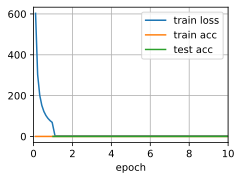

In [44]:
# Max Pooling + RelU 
npx.set_np()

netMP_RelU = nn.Sequential()
netMP_RelU.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120, activation='relu'),
        nn.Dense(84, activation='relu'),
        nn.Dense(10))

lr, num_epochs = 0.9, 10
train_ch6(netMP_RelU, train_iter, test_iter, num_epochs, lr)
## Accidentally ran with Chapter7 Input Data Spec (last cell)

loss 2.303, train acc 0.097, test acc 0.100
1056.5 examples/sec on gpu(0)


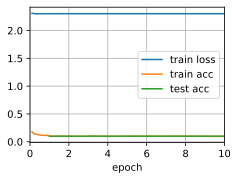

In [45]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

lr, num_epochs = 0.9, 10
train_ch6(netMP_RelU, train_iter, test_iter, num_epochs, lr)

loss 0.169, train acc 0.937, test acc 0.906
1047.5 examples/sec on gpu(0)


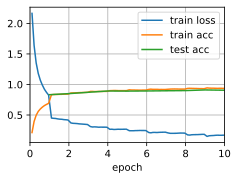

In [46]:
lr, num_epochs = 0.09, 10
train_ch6(netMP_RelU, train_iter, test_iter, num_epochs, lr)

loss 2.303, train acc 0.100, test acc 0.100
12013.9 examples/sec on gpu(0)


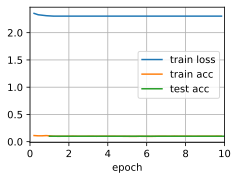

In [21]:
# Max Pooling + RelU + more Conv Filters
npx.set_np()

netMP_RelU_ConvF = nn.Sequential()
netMP_RelU_ConvF.add(
    nn.Conv2D(channels=10, kernel_size=5, padding=2, activation='relu'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Conv2D(channels=20, kernel_size=5, activation='relu'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Dense(120, activation='relu'),
    nn.Dense(84, activation='relu'),
    nn.Dense(10))

lr, num_epochs = 0.9, 10
train_ch6(netMP_RelU_ConvF, train_iter, test_iter, num_epochs, lr)

loss 2.303, train acc 0.098, test acc 0.100
869.3 examples/sec on gpu(0)


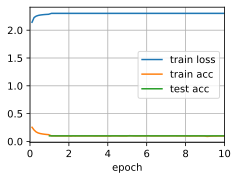

In [47]:
lr, num_epochs = 0.09, 10
train_ch6(netMP_RelU_ConvF, train_iter, test_iter, num_epochs, lr)

loss 0.255, train acc 0.903, test acc 0.886
11890.2 examples/sec on gpu(0)


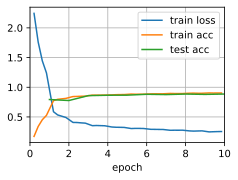

In [22]:
lr, num_epochs = 0.5, 10
train_ch6(netMP_RelU_ConvF, train_iter, test_iter, num_epochs, lr)

loss 0.293, train acc 0.889, test acc 0.885
10474.6 examples/sec on gpu(0)


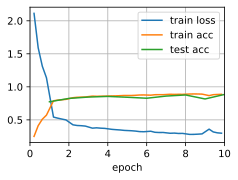

In [26]:
# Max Pooling + RelU + Lower Learning Rate + more Conv Layers
npx.set_np()

netMP_RelU_ConvL1 = nn.Sequential()
netMP_RelU_ConvL1.add(
    nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='relu'),
    nn.Conv2D(channels=6, kernel_size=2, padding=2, activation='relu'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Conv2D(channels=16, kernel_size=5, activation='relu'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Dense(120, activation='relu'),
    nn.Dense(84, activation='relu'),
    nn.Dense(10))

lr, num_epochs = 0.5, 10
train_ch6(netMP_RelU_ConvL1, train_iter, test_iter, num_epochs, lr)

loss 0.353, train acc 0.871, test acc 0.852
17320.5 examples/sec on gpu(0)


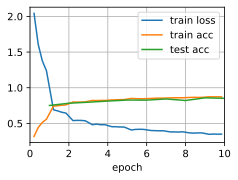

In [12]:
lr, num_epochs = 0.05, 10
train_ch6(netMP_RelU_ConvL1, train_iter, test_iter, num_epochs, lr)

loss 2.303, train acc 0.100, test acc 0.100
10334.1 examples/sec on gpu(0)


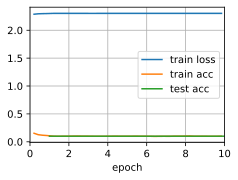

In [27]:
# Max Pooling + RelU + Lower Learning Rate + more Conv Layers
npx.set_np()

netMP_RelU_ConvL2 = nn.Sequential()
netMP_RelU_ConvL2.add(
    nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='relu'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Conv2D(channels=6, kernel_size=2, padding=2, activation='relu'),
    nn.Conv2D(channels=16, kernel_size=5, activation='relu'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Dense(120, activation='relu'),
    nn.Dense(84, activation='relu'),
    nn.Dense(10))

lr, num_epochs = 0.5, 10
train_ch6(netMP_RelU_ConvL2, train_iter, test_iter, num_epochs, lr)

loss 0.308, train acc 0.887, test acc 0.871
16460.4 examples/sec on gpu(0)


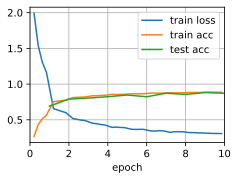

In [13]:
lr, num_epochs = 0.05, 10
train_ch6(netMP_RelU_ConvL2, train_iter, test_iter, num_epochs, lr)

loss 2.303, train acc 0.100, test acc 0.100
11383.0 examples/sec on gpu(0)


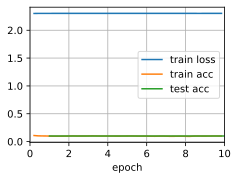

In [28]:
# Max Pooling + RelU + Lower Learning Rate + more Conv Layers
npx.set_np()

netMP_RelU_ConvL3 = nn.Sequential()
netMP_RelU_ConvL3.add(
    nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='relu'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Conv2D(channels=16, kernel_size=2, padding=2, activation='relu'),
    nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Dense(120, activation='relu'),
    nn.Dense(84, activation='relu'),
    nn.Dense(10))

lr, num_epochs = 0.5, 10
train_ch6(netMP_RelU_ConvL3, train_iter, test_iter, num_epochs, lr)

loss 0.350, train acc 0.872, test acc 0.865
16114.5 examples/sec on gpu(0)


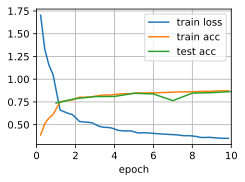

In [14]:
lr, num_epochs = 0.05, 10
train_ch6(netMP_RelU_ConvL3, train_iter, test_iter, num_epochs, lr)

loss 2.303, train acc 0.098, test acc 0.100
1338.2 examples/sec on gpu(0)


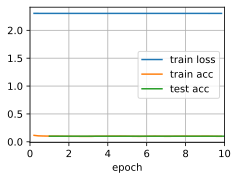

In [39]:
## Alex Net (Fat Net - LoL)
npx.set_np()

AlexNet_ = nn.Sequential()
AlexNet_.add(
    nn.Conv2D(channels=96, kernel_size=11, padding=0, strides=4, activation='relu'),
    nn.MaxPool2D(pool_size=3, strides=2),
    nn.Conv2D(channels=256, kernel_size=5, padding=5, strides=1, activation='relu'),
    nn.MaxPool2D(pool_size=3, strides=2),
    nn.Conv2D(channels=384, kernel_size=3, padding=3, strides=1, activation='relu'),
    nn.MaxPool2D(pool_size=3, strides=1),
    nn.Conv2D(channels=256, kernel_size=3, padding=3, strides=1, activation='relu'),
    nn.MaxPool2D(pool_size=3, strides=1),
    nn.Dense(9216, activation='relu'),
    nn.Dense(4096, activation='relu'),
    nn.Dense(4096, activation='relu'),
    nn.Dense(10))

lr, num_epochs = 0.5, 10
train_ch6(AlexNet_, train_iter, test_iter, num_epochs, lr)

loss 0.520, train acc 0.814, test acc 0.837
2064.7 examples/sec on gpu(0)


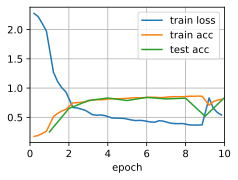

In [15]:
lr, num_epochs = 0.05, 10
train_ch6(AlexNet_, train_iter, test_iter, num_epochs, lr)

loss 0.328, train acc 0.879, test acc 0.895
754.1 examples/sec on gpu(0)


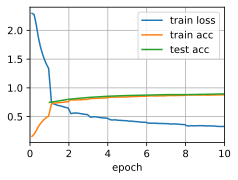

In [41]:
## From Chapter 7
import d2l
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

AlexNet_ch7 = nn.Sequential()
AlexNet_ch7.add(
    nn.Conv2D(96, kernel_size=11, strides=4, activation='relu'),
    nn.MaxPool2D(pool_size=3, strides=2),
    nn.Conv2D(256, kernel_size=5, padding=2, activation='relu'),
    nn.MaxPool2D(pool_size=3, strides=2),
    nn.Conv2D(384, kernel_size=3, padding=1, activation='relu'),
    nn.Conv2D(384, kernel_size=3, padding=1, activation='relu'),
    nn.Conv2D(256, kernel_size=3, padding=1, activation='relu'),
    nn.MaxPool2D(pool_size=3, strides=2),
    nn.Dense(4096, activation="relu"), nn.Dropout(0.5),
    nn.Dense(4096, activation="relu"), nn.Dropout(0.5),
    nn.Dense(10))

batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

lr, num_epochs = 0.01, 10
d2l.train_ch6(AlexNet_ch7, train_iter, test_iter, num_epochs, lr)